# Mini Projet: Mouvement rétrograde de Mars

## Préliminaire

On peut considérer que Mars comme la Terre suit un mouvement circulaire et uniforme dans le référentiel héliocentrique.

Les équation de ce type de mouvement sont les équations d'un cercle.

Dans les coordonnées cartésienne:

Pour un cercle de rayon R, un mouvement de période T et de phase a l'origine,

$$ X(t) = R cos(\frac{2 \pi}{T}t + \phi)$$

$$ Y(t) = R sin(\frac{2 \pi}{T}t + \phi)$$

On peut noter $\omega = \frac{2 \pi}{T}$ 

## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Objectifs

L'objectif principal est de modéliser le mouvement rétrougrade de Mars du point de vue de la Terre et le comparer avec des données réels.

Pour accomplire cette objectif il faudra:

1. Modéliser les orbites de la Terre et Mars 
2. Trouver la relation d'angle entre l'axe des abscisses et la droite coupant la Terre et Mars
3. Choisir l'angle $\phi$ (la phase à l'origine)
4. Comparer le modéle avec la réalité

## 1] Modélisation des orbites

Pour modéliser l'orbite de la Terre et de Mars, nous allons utiliser les relations de X et Y exprimées dans les préliminaires.

### Constantes

In [2]:
R_t = 1.0 # UA
R_m = 1.52371 # UA
w_t = 2 * np.pi / 365.256 # j^-1
w_m = 2 * np.pi / 686.885 # j^-1

### Modélisations via discrétisation

Pour la discrétisation nous allons utiliser un pas de temps de 1 jour

Nous allons enregistrer l'ensemble des courbes sur un dataframe de pandas pour simplifier la gestion des données.

La génération de ces orbites dépend de la phase à l'origine qui va être définie plus tard, nous allons donc effectuer la création de donnée dans une fonction `gen_orbit`

In [4]:
def gen_orbit(radius: float, pulsation: float, phi: float, t: np.ndarray):
    """
    Generate an orbit
    
     pulsation and t must have the same unit
    
    return 2 ndarray X and Y in the same unit as radius adn the same length as t
    """
    X = radius * np.cos(pulsation * t + phi)
    Y = radius * np.sin(pulsation * t + phi)
    return X, Y


def gen_orbits(phi: float = 0, dt: float = 1, t_origin = 0):
    """
    Generate orbits for Earth and Mars with phi (see above) and the discretisation param dt
    t_origin is the date where the date will be t=0 (in day)
    phi should be in radian
    """
    t = np.arange(-t_origin, 365.2 - t_origin, dt) 
    t_index = pd.to_datetime(t, unit='d', origin='2016-05-25')
    X_t, Y_t = gen_orbit(R_t, w_t, phi, t)
    X_m, Y_m = gen_orbit(R_m, w_m, phi, t)
    data = {
        "X terre": X_t,
        "Y terre": Y_t,
        "X mars": X_m,
        "Y mars": Y_m,
    }
    df = pd.DataFrame(data=data, index=t_index)
    return df

### Affichage pour vérification

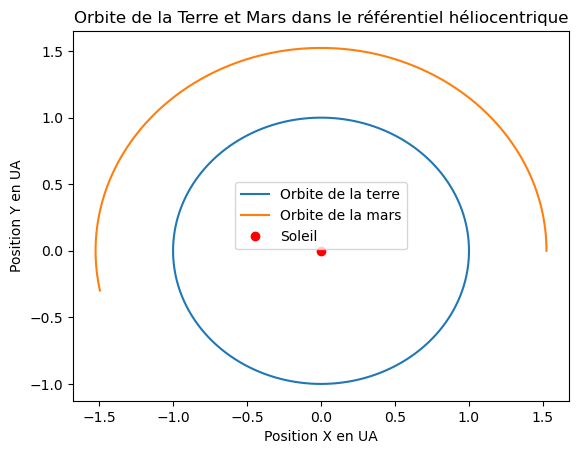

In [5]:
df_test = gen_orbits()
plt.plot(df_test['X terre'], df_test['Y terre'], label="Orbite de la terre")
plt.plot(df_test['X mars'], df_test['Y mars'], label="Orbite de la mars")
plt.plot(0,0, 'ro', label="Soleil")
plt.xlabel("Position X en UA")
plt.ylabel("Position Y en UA")
plt.title("Orbite de la Terre et Mars dans le référentiel héliocentrique")
plt.legend()

## 2 Relation d'angle

La droite coupant la Terre et Mars et la droite portée par le vecteur TM qui simplement la différence entre les deux coordonnées.

En s'appuyant sur la relation $tan(\phi) = \frac{Y}{X}$, on peut détermnier $\phi$.

Encore une fois on ne connait toujours pas l'angle à l'origine donc nous allons exprimer $\phi$ dans une fonction

In [6]:
def calc_phi(df: pd.DataFrame):
    dx_TM = df['X mars'] - df['X terre']
    dy_TM = df['Y mars'] - df['Y terre']
    df["phi"] = np.rad2deg(np.arctan2(dy_TM, dx_TM))
    return df

### Affichage pour vérification

Text(0.5, 1.0, 'Angle apparent de Mars du point de vue de la Terre')

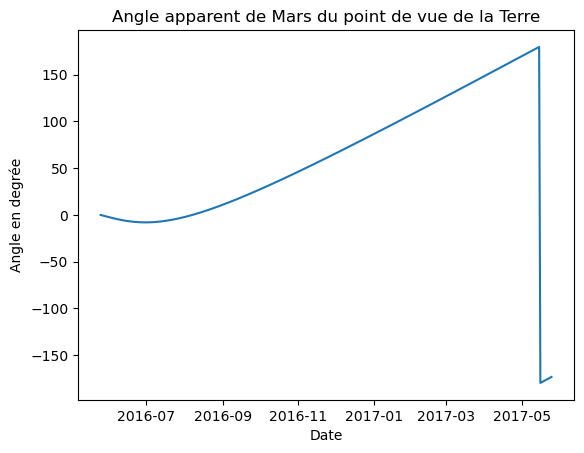

In [7]:
df_test = calc_phi(df_test)
plt.plot(df_test.index, df_test["phi"])
plt.xlabel("Date")
plt.ylabel("Angle en degrée")
plt.title("Angle apparent de Mars du point de vue de la Terre")

On remarque qu'on pas le mouvement rétrougrade sur cette figure.

Il faut définir les parametre du model pour le voir

## 3] Choix de $\phi$

On sait que le centre de la boucle du mouvement rétrougrade est le moment où le soleil, la Terre et Mars sont aligné. De plus ce moment à lieu le 25/05/2016 et la longitude est de 240.5°

Donc il faut que le 25/05/2016, l'angle soit de 240.5°

In [8]:
df = gen_orbits(phi=np.deg2rad(240.5), t_origin=146) # 146 est pour que le 25/05/2016 (qui est le 146e jour de l'année 2016) soit la date t = 0
df = calc_phi(df)

### Affichage pour vérification

Text(0.5, 1.0, 'Angle apparent de Mars du point de vue de la Terre')

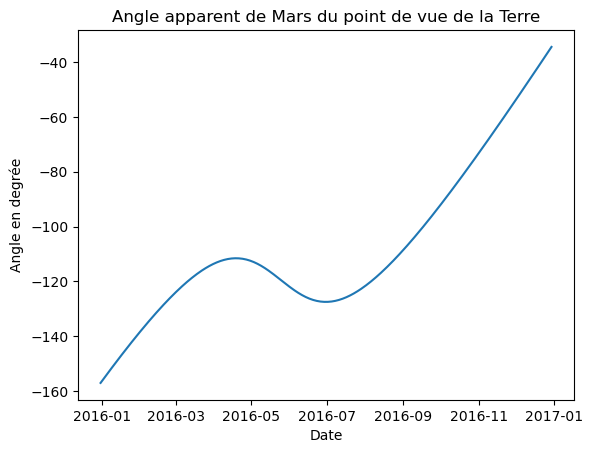

In [9]:
plt.plot(df.index, df["phi"])
plt.xlabel("Date")
plt.ylabel("Angle en degrée")
plt.title("Angle apparent de Mars du point de vue de la Terre")

On voit que le mouvement rétrougrade semble se coller à la réalité, vérifions ça...

## 4] Comparaison avec l'expérience

### Chargement des données expérimentale

In [10]:
exp = pd.read_csv("DataMars.csv", comment="#")

In [11]:
df["phi"] = df["phi"] + 360 # Seul la valeur positive est comparable a l'experience

In [12]:
exp["Date"]= pd.DatetimeIndex(exp["Date"]) # Convertie le temps pour le rendre compatible avec le modele

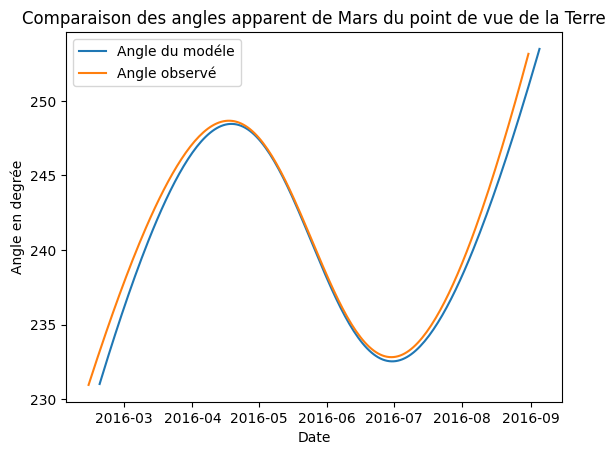

In [102]:
exp_selec = exp.iloc[350:550] # Sélectionner uniquement ce qui est intéressant pour comparer
model_selec = df.iloc[50:250]
plt.plot(model_selec.index, model_selec["phi"], label="Angle du modéle")
plt.plot(exp_selec["Date"], exp_selec["Longitude (decimal)"], label="Angle observé")
plt.xlabel("Date")
plt.ylabel("Angle en degrée")
plt.title("Comparaison des angles apparent de Mars du point de vue de la Terre")
plt.legend()

## 5] Conclusion

### Resultats

On remarque que le moddèle correspond bien vers mai au données experimental.

On a bien le mouvement retrougrade de Mars par rapport à la Terre.

Cependant, on remarque que au bout de 3 mois (avant ou après), le modèle ne colle plus au données experimental. Ce décalage est surement dû à l'hypothèse des elipse circulaire de Mars et de la Terre